In [ ]:
#QCI dirac-1 y dirac-3 10/04/2025

In [1]:
# Graph (Primer)
num_nodes = 4
start_node = 0
end_node = num_nodes - 1
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
weights = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
P = sum(weights.values()) + 1
graph_layout = {0: [-1, 0], 1: [0, 1], 2: [0, -1], 3: [1, 0]}

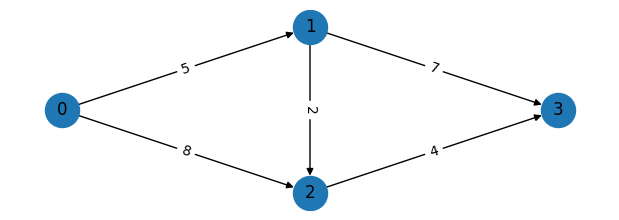

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Imprime un grafo dirigido pesado
def print_graph(graph_nodes, graph_edges, layout=None):
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from(graph_nodes)

    # Edges
    for pair, weight in graph_edges.items():
        G.add_edge(pair[0], pair[1], weight=weight)

    # Print graph
    if layout is None:
        layout = nx.spring_layout(G)

    plt.figure(3, figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)
    # plt.savefig("../../latex/resultados/img/segundo_grafo.png")

print_graph(range(num_nodes), weights, layout=graph_layout)

In [3]:
import dimod
import numpy as np

# Inicializar BQM
bqm = dimod.BinaryQuadraticModel("BINARY")

# Función de coste: pesos de las aristas
for e in range(len(edges)):
    bqm.add_variable(edges[e], weights[edges[e]])

# Restricción: Nodo de inicio 
c_start = [(edges[e], 1) for e in range(len(edges)) if edges[e][0] == start_node]
bqm.add_linear_equality_constraint(c_start, constant=-1, lagrange_multiplier=P)

# Restricción: Nodo final
c_end = [(edges[e], 1) for e in range(len(edges)) if edges[e][1] == end_node]
bqm.add_linear_equality_constraint(c_end, constant=-1, lagrange_multiplier=P)

# Restricciones: Nodos intermedios 
for node in range(1, end_node):
    c_inter = []
    for e in range(len(edges)):
        i, j = edges[e]
        if j == node:
            c_inter.append((edges[e], 1))  # Arista entrante
        elif i == node:
            c_inter.append((edges[e], -1))  # Arista saliente
    bqm.add_linear_equality_constraint(c_inter, constant=0, lagrange_multiplier=P)

print("\n--- Modelo BQM en Dimod ---")
print("Variables (aristas) y términos lineales:", bqm.linear)
print("Términos cuadráticos (restricciones):", bqm.quadratic)


--- Modelo BQM en Dimod ---
Variables (aristas) y términos lineales: {(0, 1): 5.0, (0, 2): 8.0, (1, 2): 56.0, (1, 3): 7.0, (2, 3): 4.0}
Términos cuadráticos (restricciones): {((0, 2), (0, 1)): 54.0, ((1, 2), (0, 1)): -54.0, ((1, 2), (0, 2)): 54.0, ((1, 3), (0, 1)): -54.0, ((1, 3), (1, 2)): 54.0, ((2, 3), (0, 2)): -54.0, ((2, 3), (1, 2)): -54.0, ((2, 3), (1, 3)): 54.0}


In [4]:
# Extraer términos lineales y cuadráticos del BQM
linear_terms = bqm.linear
quadratic_terms = bqm.quadratic

# Mapear aristas a índices numéricos consecutivos
variables = sorted(linear_terms.keys())
var_to_index = {v: i for i, v in enumerate(variables)}

# Inicializar matriz QUBO
n = len(variables)
qubo_matrix = np.zeros((n, n))

# Llenar términos lineales (diagonal)
for var, coeff in linear_terms.items():
    idx = var_to_index[var]
    qubo_matrix[idx, idx] = coeff

# Llenar términos cuadráticos (simétricos)
for (var1, var2), coeff in quadratic_terms.items():
    idx1 = var_to_index[var1]
    idx2 = var_to_index[var2]
    qubo_matrix[idx1, idx2] += coeff /2
    # Forzar simetría
    qubo_matrix[idx2, idx1] += coeff /2

# Verificar simetría
assert np.allclose(qubo_matrix, qubo_matrix.T), "La matriz QUBO no es simétrica"

In [5]:
print("Matriz QUBO generada:")
print(qubo_matrix)
print("\nTérminos lineales (diagonal):", np.diag(qubo_matrix))
print("Términos cuadráticos (superior):\n", np.triu(qubo_matrix, k=1))

Matriz QUBO generada:
[[  5.  27. -27. -27.   0.]
 [ 27.   8.  27.   0. -27.]
 [-27.  27.  56.  27. -27.]
 [-27.   0.  27.   7.  27.]
 [  0. -27. -27.  27.   4.]]

Términos lineales (diagonal): [ 5.  8. 56.  7.  4.]
Términos cuadráticos (superior):
 [[  0.  27. -27. -27.   0.]
 [  0.   0.  27.   0. -27.]
 [  0.   0.   0.  27. -27.]
 [  0.   0.   0.   0.  27.]
 [  0.   0.   0.   0.   0.]]


In [ ]:
import os
import qci_client as qc

#Configura la API de QCI
os.environ['QCI_API_URL'] = 'https://api.qci-prod.com'  
os.environ['QCI_TOKEN'] = 'TOKEN'

#Crear cliente de QCI
client = qc.QciClient()

#Convertir la matriz QUBO a un formato adecuado
#Usamos numpy.ndarray
qubo_matrix = np.array(qubo_matrix)

#Subir el archivo QUBO a QCI
file_def = {
    "file_name": "bqm_to_qubo_example",
    "file_config": {"qubo": {"data": qubo_matrix}}  
}
response = client.upload_file(file=file_def)
file_id = response["file_id"]
print(f"File ID: {file_id}")

#Crear y enviar el trabajo a QCI 
job_body = client.build_job_body(
    job_type="sample-qubo",  
    qubo_file_id=file_id,
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
job_response = client.process_job(job_body=job_body)

#Ver el ID del trabajo
job_id = job_response.get("job_info", {}).get("job_id", "Desconocido")
print(f"Trabajo enviado con ID: {job_id}")

#Esperar hasta que el trabajo esté completado
import time

job_status = client.get_job_status(job_id=job_id)
while job_status["status"] not in ["COMPLETED", "FAILED"]:
    print(f"Estado del trabajo: {job_status['status']}")
    time.sleep(5)
    job_status = client.get_job_status(job_id=job_id)

#Obtener resultados del trabajo
if job_status["status"] == "COMPLETED":
    results = client.get_job_results(job_id=job_id)
    print("Resultados obtenidos:")
    print(results)
else:
    print("El trabajo falló.")

#Obtener la mejor solución
solutions = results["results"]["solutions"]
best_solution = solutions[0]
print("Mejor solución:", best_solution)


File ID: 685d72915e085526322a8c11
2025-06-26 18:17:22 - Dirac allocation balance = 26 s
2025-06-26 18:17:22 - Job submitted: job_id='685d72925e5ac839b11f24cd'
2025-06-26 18:17:22 - QUEUED


In [ ]:
#Índices activos
active_indices = [i for i, val in enumerate(best_solution) if val == 1]  

#Mapear índices a aristas activas
active_edges = [edges[i] for i in active_indices]

# Reconstruir el camino (igual que en Dimod)
path = []
current_node = start_node
while current_node != end_node:
    for edge in active_edges:
        if edge[0] == current_node:
            path.append(edge)
            current_node = edge[1]
            break

print("Camino más corto encontrado:", path)
print("Peso total:", sum(weights[edge] for edge in path))

# Visualización (igual que en Dimod)
G = nx.DiGraph()
G.add_nodes_from(range(num_nodes))
for pair, weight in weights.items():
    G.add_edge(pair[0], pair[1], weight=weight)

plt.figure(figsize=(6, 2))
pos = graph_layout
nx.draw(G, pos, with_labels=True, node_size=600)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Resaltar el camino
nx.draw_networkx_edges(G, pos, edgelist=path, edge_color='r', width=2)
plt.show()

In [ ]:
from itertools import product
import numpy as np
import pandas as pd
from tabulate import tabulate

# Parámetros conocidos
opt_solution = (1, 0, 1, 0, 1)  # solución óptima como tupla
opt_value = 11
num_shots = sum(results["results"]["counts"])

# Procesar resultados
solutions = results["results"]["solutions"]
counts = results["results"]["counts"]

# Contar ocurrencias
all_combinations = list(product([0, 1], repeat=len(solutions[0])))
count_dict = {comb: 0 for comb in all_combinations}
for solution, count in zip(solutions, counts):
    count_dict[tuple(solution)] += count

# Mostrar tabla de combinaciones observadas
table_data = [[comb, count] for comb, count in count_dict.items() if count > 0]
print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=["Combinación", "Conteo"], tablefmt="pretty"))

In [ ]:
from qiskit.visualization import plot_histogram

# Formatear los datos para Qiskit
formatted_counts = {"".join(map(str, k)): v for k, v in count_dict.items() if v > 0}

# Dibujar histograma con Qiskit
plot_histogram(formatted_counts, title="Histograma de combinaciones (Qiskit)")


In [ ]:
from itertools import product
import numpy as np
import pandas as pd
from tabulate import tabulate


# Parámetros conocidos
opt_solution = (1, 0, 1, 0, 1)  # solución óptima como tupla
opt_value = 11
num_shots = sum(results["results"]["counts"])

# Obtener tiempo por muestra
device_time_s = results["job_info"]["job_result"]["device_usage_s"]
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# Procesar resultados
solutions = results["results"]["solutions"]
counts = results["results"]["counts"]

# Contar ocurrencias
all_combinations = list(product([0, 1], repeat=len(solutions[0])))
count_dict = {comb: 0 for comb in all_combinations}
for solution, count in zip(solutions, counts):
    count_dict[tuple(solution)] += count

# Mostrar tabla de combinaciones observadas
table_data = [[comb, count] for comb, count in count_dict.items() if count > 0]
print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=["Combinación", "Conteo"], tablefmt="pretty"))

# --- MÉTRICAS ---

def calculate_P_GS_and_TTS(count_dict, opt_states, t_sample):
    success_counts = sum(count_dict[state] for state in opt_states)
    total_counts = sum(count_dict.values())
    p_gs = success_counts / total_counts

    if p_gs == 1.0:
        tts = t_sample
    elif p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))
    return p_gs, tts

# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(count_dict, [opt_solution], t_sample)

# Mostrar métricas
print("\nMétricas:")
print(f"P_GS: {p_gs:.4f}")
print(f"TTS: {tts:.2f} ms")

# Mostrar como tabla (pandas)
df = pd.DataFrame({
    "Instance": ["(QCI Dirac1 Job)"],
    "Opt": [opt_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})

print("\nTabla de métricas:")
display(df)


In [ ]:
#Solución con Dirac-3

In [7]:
num_nodes = 4
start_node = 0
end_node = num_nodes - 1
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
weights = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
P = sum(weights.values()) + 1
graph_layout = {0: [-1, 0], 1: [0, 1], 2: [0, -1], 3: [1, 0]}

import dimod
import numpy as np

#Inicializar BQM
bqm = dimod.BinaryQuadraticModel("BINARY")

#Función de coste: pesos de las aristas
for e in range(len(edges)):
    bqm.add_variable(edges[e], weights[edges[e]])

#Restricción: Nodo de inicio
c_start = [(edges[e], 1) for e in range(len(edges)) if edges[e][0] == start_node]
bqm.add_linear_equality_constraint(c_start, constant=-1, lagrange_multiplier=P)

#Restricción: Nodo final
c_end = [(edges[e], 1) for e in range(len(edges)) if edges[e][1] == end_node]
bqm.add_linear_equality_constraint(c_end, constant=-1, lagrange_multiplier=P)

#Restricciones: Nodos intermedios
for node in range(1, end_node):
    c_inter = []
    for e in range(len(edges)):
        i, j = edges[e]
        if j == node:
            c_inter.append((edges[e], 1))  # Arista entrante
        elif i == node:
            c_inter.append((edges[e], -1))  # Arista saliente
    bqm.add_linear_equality_constraint(c_inter, constant=0, lagrange_multiplier=P)

print("\n--- Modelo BQM en Dimod ---")
print("Variables (aristas) y términos lineales:", bqm.linear)
print("Términos cuadráticos (restricciones):", bqm.quadratic)

#Extraer términos lineales y cuadráticos del BQM
linear_terms = bqm.linear
quadratic_terms = bqm.quadratic

#Mapear aristas a índices numéricos consecutivos
variables = sorted(linear_terms.keys())
var_to_index = {v: i for i, v in enumerate(variables)}

#Inicializar matriz QUBO
n = len(variables)
qubo_matrix = np.zeros((n, n))

#Llenar términos lineales (diagonal)
for var, coeff in linear_terms.items():
    idx = var_to_index[var]
    qubo_matrix[idx, idx] = coeff

#Llenar términos cuadráticos (simétricos)
for (var1, var2), coeff in quadratic_terms.items():
    idx1 = var_to_index[var1]
    idx2 = var_to_index[var2]
    qubo_matrix[idx1, idx2] += coeff /2
    # Forzar simetría
    qubo_matrix[idx2, idx1] += coeff /2

#Verificar simetría
assert np.allclose(qubo_matrix, qubo_matrix.T), "La matriz QUBO no es simétrica"



--- Modelo BQM en Dimod ---
Variables (aristas) y términos lineales: {(0, 1): 5.0, (0, 2): 8.0, (1, 2): 56.0, (1, 3): 7.0, (2, 3): 4.0}
Términos cuadráticos (restricciones): {((0, 2), (0, 1)): 54.0, ((1, 2), (0, 1)): -54.0, ((1, 2), (0, 2)): 54.0, ((1, 3), (0, 1)): -54.0, ((1, 3), (1, 2)): 54.0, ((2, 3), (0, 2)): -54.0, ((2, 3), (1, 2)): -54.0, ((2, 3), (1, 3)): 54.0}


In [ ]:
import os
os.environ['QCI_API_URL'] = 'https://api.qci-prod.com'
os.environ['QCI_TOKEN'] = 'Token'

import qci_client as qc


#Crear cliente de QCI
client = qc.QciClient()

In [8]:
print(qubo_matrix)

[[  5.  27. -27. -27.   0.]
 [ 27.   8.  27.   0. -27.]
 [-27.  27.  56.  27. -27.]
 [-27.   0.  27.   7.  27.]
 [  0. -27. -27.  27.   4.]]


In [9]:

data_int_problem = []

#Términos lineales (de la diagonal)
for i in range(qubo_matrix.shape[0]):
    if qubo_matrix[i, i] != 0:
        data_int_problem.append({
            'idx': [0, i+1], 
            'val': float(qubo_matrix[i, i]) # Coeficiente de término lineal
        })

#Términos cuadráticos (fuera de la diagonal)
for i in range(qubo_matrix.shape[0]):
    for j in range(i + 1, qubo_matrix.shape[1]):  # Evitar duplicados
        if qubo_matrix[i, j] != 0:
            data_int_problem.append({
                'idx': [i+1, j+1],  # Término cuadrático entre dos variables
                'val': float(qubo_matrix[i, j])  # Coeficiente de término cuadrático
            })

#Imprimir el formato necesario
print(data_int_problem)


[{'idx': [0, 1], 'val': 5.0}, {'idx': [0, 2], 'val': 8.0}, {'idx': [0, 3], 'val': 56.0}, {'idx': [0, 4], 'val': 7.0}, {'idx': [0, 5], 'val': 4.0}, {'idx': [1, 2], 'val': 27.0}, {'idx': [1, 3], 'val': -27.0}, {'idx': [1, 4], 'val': -27.0}, {'idx': [2, 3], 'val': 27.0}, {'idx': [2, 5], 'val': -27.0}, {'idx': [3, 4], 'val': 27.0}, {'idx': [3, 5], 'val': -27.0}, {'idx': [4, 5], 'val': 27.0}]


In [104]:
"""data_int_problem = [
    # Términos lineales: cada uno se codifica con [0, variable] (variable en formato 1-basado)
    {'idx': [0, 1], 'val': 5.0},   # 5.0·x₁
    {'idx': [0, 2], 'val': 8.0},   # 8.0·x₂
    {'idx': [0, 3], 'val': 56.0},  # 56.0·x₃
    {'idx': [0, 4], 'val': 7.0},   # 7.0·x₄
    {'idx': [0, 5], 'val': 4.0},    # 4.0·x₅

    # Términos cuadráticos: se usan los índices 1-basados directamente
    {'idx': [1, 2], 'val': 27.0},    # 54.0·x₁x₂
    {'idx': [1, 3], 'val': -27.0},   # -54.0·x₁x₃
    {'idx': [1, 4], 'val': -27.0},   # -54.0·x₁x₄
    {'idx': [2, 3], 'val': 27.0},    # 54.0·x₂x₃
    {'idx': [2, 5], 'val': -27.0},   # -54.0·x₂x₅
    {'idx': [3, 4], 'val': 27.0},    # 54.0·x₃x₄
    {'idx': [3, 5], 'val': -27.0},   # -54.0·x₃x₅
    {'idx': [4, 5], 'val': 27.0}     # 54.0·x₄x₅
]"""

In [ ]:
file_int_problem = {
    "file_name": "dirac_3_prueba",
    "file_config": {
        "polynomial": {
            "num_variables": 5,  # Número total de variables
            "min_degree": 1,     # Mínimo grado permitido (1 como mínimo, dirac-3 no acepta constantes)
            "max_degree": 2,     # Máximo grado
            "data": data_int_problem,
        }
    }
}
file_response_int_problem = client.upload_file(file=file_int_problem)
file_response_int_problem

In [ ]:
#Condifguración
job_body_int_problem = client.build_job_body(
    job_type='sample-hamiltonian-integer',
    job_name='test_integer_variable_hamiltonian_job',
    job_tags=['tag1', 'tag2'],
    job_params={
        'device_type': 'dirac-3',
        'num_samples': 1,  
        'relaxation_schedule': 1, 
        'num_levels': [2, 2, 2, 2, 2],  # Número de valores que puede tomar cada variable, en este caso 0 y 1
    },
    polynomial_file_id=file_response_int_problem['file_id'],
)
print(job_body_int_problem)

In [ ]:
#Envío a QCI dirac-3

job_response_int_problem = client.process_job(job_body=job_body_int_problem)

print("Found solutions:")
print(job_response_int_problem['results']['solutions'])
print("with energies:")
print(job_response_int_problem['results']['energies'])
print("and counts:")
print(job_response_int_problem['results']['counts'])

In [ ]:
best_solution=job_response_int_problem['results']['solutions'][0]
print("Mejor solución:", best_solution)
active_indices = [i for i, val in enumerate(best_solution) if val == 1]  # Índices activos

# Mapear índices a aristas activas
active_edges = [edges[i] for i in active_indices]

# Reconstruir el camino 
path = []
current_node = start_node
while current_node != end_node:
    for edge in active_edges:
        if edge[0] == current_node:
            path.append(edge)
            current_node = edge[1]
            break

print("Camino más corto encontrado:", path)
print("Peso total:", sum(weights[edge] for edge in path))

# Visualización 
G = nx.DiGraph()
G.add_nodes_from(range(num_nodes))
for pair, weight in weights.items():
    G.add_edge(pair[0], pair[1], weight=weight)

plt.figure(figsize=(6, 2))
pos = graph_layout
nx.draw(G, pos, with_labels=True, node_size=600)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Resaltar el camino
nx.draw_networkx_edges(G, pos, edgelist=path, edge_color='r', width=2)
plt.show()

In [ ]:
# Graph (Primer)
num_nodes = 4
start_node = 0
end_node = num_nodes - 1
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
weights = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
P = sum(weights.values()) + 1
graph_layout = {0: [-1, 0], 1: [0, 1], 2: [0, -1], 3: [1, 0]}

In [ ]:
import dimod
import numpy as np

# Inicializar BQM
bqm = dimod.BinaryQuadraticModel("BINARY")

# Función de coste: pesos de las aristas
for e in range(len(edges)):
    bqm.add_variable(edges[e], weights[edges[e]])

# Restricción: Nodo de inicio 
c_start = [(edges[e], 1) for e in range(len(edges)) if edges[e][0] == start_node]
bqm.add_linear_equality_constraint(c_start, constant=-1, lagrange_multiplier=P)

# Restricción: Nodo final
c_end = [(edges[e], 1) for e in range(len(edges)) if edges[e][1] == end_node]
bqm.add_linear_equality_constraint(c_end, constant=-1, lagrange_multiplier=P)

# Restricciones: Nodos intermedios 
for node in range(1, end_node):
    c_inter = []
    for e in range(len(edges)):
        i, j = edges[e]
        if j == node:
            c_inter.append((edges[e], 1))  # Arista entrante
        elif i == node:
            c_inter.append((edges[e], -1))  # Arista saliente
    bqm.add_linear_equality_constraint(c_inter, constant=0, lagrange_multiplier=P)

print("\n--- Modelo BQM en Dimod ---")
print("Variables (aristas) y términos lineales:", bqm.linear)
print("Términos cuadráticos (restricciones):", bqm.quadratic)

In [ ]:
linear_terms = [float(x) for x in bqm.linear_biases]
row_indices = [int(x) for x in bqm.quadratic.row_indices]
col_indices = [int(x) for x in bqm.quadratic.col_indices]
quadratic_terms = [float(x) for x in bqm.quadratic.biases]
num_variables = len(bqm_vectors.labels)

# Crear la matriz Q como un array de NumPy (cuadrática)
Q = np.zeros((num_variables, num_variables))  # Inicializar la matriz Q de tamaño num_variables x num_variables

# Llenar la matriz con los términos lineales
for i, bias in enumerate(linear_terms):
    Q[i, i] = bias

# Llenar la matriz con los términos cuadráticos
for i, j, bias in zip(row_indices, col_indices, quadratic_terms):
    Q[i, j] = bias /2
    Q[j, i] = bias /2  # La matriz es simétrica, por lo que se llena en ambos sentidos

Q = Q.astype(float)
# 4️Crear la estructura final `bqm_qci` con la forma esperada
bqm_qci = {
    'file_name': "smallest_objective.json",
    'file_config': {'qubo': {"data": Q}}  # Convertimos Q a lista para que sea JSON serializable
}



In [ ]:
import json
from tabulate import tabulate

# Mostrar el modelo BQM
print("\n--- Modelo BQM en Dimod ---")
print("\nTérminos lineales:")
for var, bias in bqm.linear.items():
    print(f"  {var}: {bias:.2f}")

print("\nTérminos cuadráticos:")
for (u, v), bias in bqm.quadratic.items():
    print(f"  ({u}, {v}): {bias:.2f}")

# Extraer información para formar la matriz Q 
linear_terms = [float(x) for x in bqm.linear_biases]
row_indices = [int(x) for x in bqm.quadratic.row_indices]
col_indices = [int(x) for x in bqm.quadratic.col_indices]
quadratic_terms = [float(x) for x in bqm.quadratic.biases]
num_variables = len(bqm.variables)

# Crear matriz Q vacía
Q = np.zeros((num_variables, num_variables))

# Agregar lineales
for i, bias in enumerate(linear_terms):
    Q[i, i] = bias

# Agregar cuadráticos (simétrica)
for i, j, bias in zip(row_indices, col_indices, quadratic_terms):
    Q[i, j] = bias /2
    Q[j, i] = bias /2

# Mostrar matriz Q como tabla
headers = [f"x{j}" for j in range(num_variables)]
print("\n--- Matriz Q (QUBO) ---")
print(tabulate(Q, headers=headers, showindex=[f"x{i}" for i in range(num_variables)], floatfmt=".2f", tablefmt="pretty"))



In [ ]:
import numpy as np
from tabulate import tabulate
import json

# Obtener lista de variables ordenadas para indexarlas
variables = list(bqm.variables)
var_index = {v: i for i, v in enumerate(variables)}  # mapa de variable a índice
num_variables = len(variables)

# Crear matriz Q vacía
Q = np.zeros((num_variables, num_variables))

# Términos lineales (diagonal)
for var, bias in bqm.linear.items():
    i = var_index[var]
    Q[i, i] = bias

# Términos cuadráticos (simétricos)
for (u, v), bias in bqm.quadratic.items():
    i = var_index[u]
    j = var_index[v]
    Q[i, j] = bias /2
    Q[j, i] = bias /2 # asegurar simetría

# Mostrar matriz Q como tabla
headers = [str(v) for v in variables]
print("\n--- Matriz Q (QUBO) ---")
print(tabulate(Q, headers=headers, showindex=headers, floatfmt=".2f", tablefmt="pretty"))


In [ ]:
from itertools import product
import numpy as np
import pandas as pd
from tabulate import tabulate

# Parámetros conocidos
opt_solution = (1, 0, 1, 0, 1)  # solución óptima como tupla
opt_value = 11
num_shots = sum(results["results"]["counts"])

# Obtener tiempo por muestra
device_time_s = results["job_info"]["job_result"]["device_usage_s"]
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# Procesar resultados
solutions = results["results"]["solutions"]
counts = results["results"]["counts"]

# Contar ocurrencias
all_combinations = list(product([0, 1], repeat=len(solutions[0])))
count_dict = {comb: 0 for comb in all_combinations}
for solution, count in zip(solutions, counts):
    count_dict[tuple(solution)] += count

# Mostrar tabla de combinaciones observadas
table_data = [[comb, count] for comb, count in count_dict.items() if count > 0]
print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=["Combinación", "Conteo"], tablefmt="pretty"))

In [ ]:
from qiskit.visualization import plot_histogram

# Formatear los datos para Qiskit
formatted_counts = {"".join(map(str, k)): v for k, v in count_dict.items() if v > 0}

# Dibujar histograma con Qiskit
plot_histogram(formatted_counts, title="Histograma de combinaciones (Qiskit)")


In [ ]:
from itertools import product
import numpy as np
import pandas as pd
from tabulate import tabulate


# Parámetros conocidos
opt_solution = (1, 0, 1, 0, 1)  # solución óptima como tupla
opt_value = 11
num_shots = sum(results["results"]["counts"])

# Obtener tiempo por muestra
device_time_s = results["job_info"]["job_result"]["device_usage_s"]
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# Procesar resultados
solutions = results["results"]["solutions"]
counts = results["results"]["counts"]

# Contar ocurrencias
all_combinations = list(product([0, 1], repeat=len(solutions[0])))
count_dict = {comb: 0 for comb in all_combinations}
for solution, count in zip(solutions, counts):
    count_dict[tuple(solution)] += count

# Mostrar tabla de combinaciones observadas
table_data = [[comb, count] for comb, count in count_dict.items() if count > 0]
print("\nConteo de todas las combinaciones:")
print(tabulate(table_data, headers=["Combinación", "Conteo"], tablefmt="pretty"))

# --- MÉTRICAS ---

def calculate_P_GS_and_TTS(count_dict, opt_states, t_sample):
    success_counts = sum(count_dict[state] for state in opt_states)
    total_counts = sum(count_dict.values())
    p_gs = success_counts / total_counts

    if p_gs == 1.0:
        tts = t_sample
    elif p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * (np.log(1 - 0.99) / np.log(1 - p_gs))
    return p_gs, tts

# Calcular métricas
p_gs, tts = calculate_P_GS_and_TTS(count_dict, [opt_solution], t_sample)

# Mostrar métricas
print("\nMétricas:")
print(f"P_GS: {p_gs:.4f}")
print(f"TTS: {tts:.2f} ms")

# Mostrar como tabla (pandas)
df = pd.DataFrame({
    "Instance": ["(QCI Dirac1 Job)"],
    "Opt": [opt_value],
    "P_GS": [p_gs],
    "t_sample (ms)": [t_sample],
    "TTS (ms)": [tts]
})

print("\nTabla de métricas:")
display(df)


In [ ]:
from qiskit.visualization import plot_histogram

# Formatear los datos para Qiskit
formatted_counts = {"".join(map(str, k)): v for k, v in count_dict.items() if v > 0}

# Dibujar histograma con Qiskit
plot_histogram(formatted_counts, title="Histograma de combinaciones (Qiskit)")
